In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import scipy
from scipy.interpolate import UnivariateSpline
import lmfit
import ray


from bio_optics.water import absorption, attenuation, backscattering, scattering, lee
from bio_optics.atmosphere import downwelling_irradiance
from bio_optics.models import hereon, model
from bio_optics.helper import resampling, utils, owt, indices, plotting

# Get data
GLORIA/GLOMAP  
Spec Bal, Jorge  
EnMAP extracts: North Sea, Baltic Sea  
PACE extracts: North Sea

In [16]:
# GLORIA dataset convolved to EnMAP bands
datasetName='GLOMAP'
df = pd.read_csv(r'Z:\projects\ongoing\EnsAD\workspace\data\insitu_GLORIA\GLORIA_Rrs_mean_Convolved_EnMAP2.csv', sep='\t')
enmap_bands = pd.read_csv(r'Z:\projects\ongoing\EnsAD\workspace\data\insitu_GLORIA\EnMAP_Spectral_Bands.txt', sep='\t')

owt_df = pd.read_csv(r'Z:\projects\ongoing\EnsAD\workspace\data\Database\Others\OWTShunBi_GLORIA\GLORIA_Subset_OACsOWT.csv')
owt_df = owt_df[['OWT', 'GLORIA_ID']]
owt = [str(a) for a in owt_df['OWT']]
owt_df['OWT'] = np.asarray(owt)

# define wavelength range and clip data
wavelengths = enmap_bands['CW (nm)'][:73].values
wavelengths = wavelengths[(wavelengths>400) & (wavelengths<750)]
pin = df['GLORIA_ID'].values
r_rs =  df.iloc[:,1:len(wavelengths)+1]

# filter GLORIA data
path3 = "E:\Documents\projects\EnsAD\\insitu_data\GLORIA\GLORIA_meta_and_lab.csv"
labData = pd.read_csv(path3, header=0, sep=',')
labDataCol = ['GLORIA_ID', 'Chla', 'Chla_plus_phaeo', 'TSS', 'aCDOM440', 'Water_type']
labData = labData[labDataCol]

IDnanRrs = np.logical_or(np.array(np.sum(np.isnan(r_rs), axis=1) > 2),
                         np.array(np.sum(r_rs == 0, axis=1) > 2))

IDchl = np.logical_and(np.logical_and(np.logical_not(np.isnan(labData['Chla'].values)),
                                      np.logical_not(np.isnan(labData['TSS'].values))),
                       np.logical_and(np.logical_not(IDnanRrs),
                                      np.logical_not(np.isnan(labData['aCDOM440'].values))))
IDchl2 = np.logical_and(
    np.logical_and(np.logical_not(np.isnan(labData['Chla_plus_phaeo'].values)),
                   np.logical_not(np.isnan(labData['TSS'].values))),
    np.logical_and(np.logical_not(IDnanRrs), np.logical_not(np.isnan(labData['aCDOM440'].values))))
ID = np.logical_or(IDchl, IDchl2)

r_rs = r_rs.loc[ID, :]
pin = pin[ID]
print(r_rs.shape, df.shape, owt_df.shape)

(3034, 59) (7572, 92) (3034, 2)


In [2]:
## Jorge: Spec Balaton
datasetName='SpecBal'
df = pd.read_csv(r'Z:\projects\ongoing\EnsAD\workspace\data\Database\Others\SpecBal_EnMap.txt', index_col=0)

r_rs = df.iloc[:,:56] 
wavelengths = df.columns[:56].values.astype(float)

In [2]:
## North Sea extracts, EnMAP
datasetName='NorthSeaEnMAPSouth20230815'
df = pd.read_csv(r'Z:\projects\ongoing\EnsAD\workspace\data\Database\\20230815_DB\\20230815_South.csv')

wavelengths = df.columns[4:84].values.astype(float)
wavelengths = wavelengths[(wavelengths>400) & (wavelengths<750)]
r_rs =  df.iloc[:,4:len(wavelengths)+4]

In [15]:
# Baltic Sea extracts, EnMAP
from netCDF4 import Dataset
datasetName='BalticEnMAP'
d = Dataset(r'Z:\projects\ongoing\EnsAD\workspace\data\Database\EnsAD_DB_V0104.nc', 'r')

nc_vars = [var for var in d.variables]
print(nc_vars)


## Baltic Sea
# ID = np.logical_and(np.logical_and(nc_fid.variables['lon'][:] > 12, nc_fid.variables['lon'][:] < 20),
#                     np.logical_and(nc_fid.variables['lat'][:] > 54, nc_fid.variables['lat'][:] < 60))
# print(np.sum(ID))


tileList = ['20230717T102603Z', '20230914T105621Z', '20230925T104142Z', '20230925T104147Z',
            '20230925T104151Z', '20230921T103824Z']
ID1 = np.asarray([tileList[0] in b for b in d.variables['Image'][:]])
for tile in tileList[1:]:
    ID2 = np.asarray([tile in b for b in d.variables['Image'][:]])
    ID1 = np.logical_or(ID1, ID2)

print(ID1)
print(np.unique(d.variables['Image'][:][ID1]))

OWT = np.asarray([str(b) for b in d['OWT'][:]])
nc_vars = [var for var in d.variables]
columns = nc_vars[4:-14]

pin = [str(a) + '_' + str(b) + '_'+ c.split('_V010')[0].split('_')[-2] for a, b, c in zip(OWT, d['index'][:], d['Image'][:])]
Rrs = np.zeros((len(OWT), len(columns)))
for i, col in enumerate(columns):
    Rrs[:, i] = d[col][:]

Rrs = Rrs[ID1,:]
pin = np.asarray(pin)
pin = pin[ID1]

wlStand = np.asarray([float(a) for a in columns])
Rrs_unc = np.zeros(Rrs.shape) + np.nanmax(Rrs) * 0.05

ID = np.array(np.sum(np.isnan(Rrs), axis=1) == 0)
Rrs = Rrs[ID, :]
Rrs_unc = Rrs_unc[ID, :]
pin = pin[ID]

wavelengths = wlStand
wavelengths = wavelengths[(wavelengths>400) & (wavelengths<750)]

r_rs = pd.DataFrame(Rrs.T[(wlStand>400) & (wlStand<750)].T)

['index', 'Image', 'lon', 'lat', '418.24', '423.874', '429.294', '434.528', '439.603', '444.549', '449.391', '454.159', '458.884', '463.584', '468.265', '472.934', '477.599', '482.265', '486.941', '491.633', '496.349', '501.094', '505.87', '510.678', '515.519', '520.397', '525.313', '530.268', '535.265', '540.305', '545.391', '550.525', '555.71', '560.947', '566.239', '571.587', '576.995', '582.464', '587.997', '593.596', '599.267', '605.011', '610.833', '616.737', '622.732', '628.797', '634.919', '641.1', '647.341', '653.643', '660.007', '666.435', '672.927', '679.485', '686.11', '692.804', '699.567', '706.401', '713.307', '720.282', '727.324', '734.431', '741.601', '748.833', '756.124', '763.472', '770.876', '778.333', '785.843', '793.402', '801.01', '808.665', '816.367', '824.112', '831.901', '839.731', '847.601', '855.509', '863.455', '871.433', '879.442', '887.478', '895.537', '902.257', 'OWT', 'Count_0', 'AC', 'Version', 'Season', 'BiomeType', 'OrbitDirection', 'SunElevationAngle

In [42]:
# Baltic Sea extracts, EnMAP
from netCDF4 import Dataset
datasetName='DBFullEnMAP'
d = Dataset(r'Z:\projects\ongoing\EnsAD\workspace\data\Database\EnsAD_DB_V0104_filtered.nc', 'r')

nc_vars = [var for var in d.variables]
print(nc_vars)

print(np.unique(d.variables['Image'][:]))

OWT = np.asarray([str(b) for b in d['OWT'][:]])
nc_vars = [var for var in d.variables]
columns = nc_vars[4:-14]

pin = [str(a) + '_' + str(b) + '_'+ c.split('_V010')[0].split('_')[-2] for a, b, c in zip(OWT, d['index'][:], d['Image'][:])]
Rrs = np.zeros((len(OWT), len(columns)))
for i, col in enumerate(columns):
    Rrs[:, i] = d[col][:]

pin = np.asarray(pin)

wlStand = np.asarray([float(a) for a in columns])
Rrs_unc = np.zeros(Rrs.shape) + np.nanmax(Rrs) * 0.05

ID = np.array(np.sum(np.isnan(Rrs), axis=1) == 0)
Rrs = Rrs[ID, :]
Rrs_unc = Rrs_unc[ID, :]
pin = pin[ID]

wavelengths = wlStand
wavelengths = wavelengths[(wavelengths>400) & (wavelengths<750)]

r_rs = pd.DataFrame(Rrs.T[(wlStand>400) & (wlStand<750)].T)
print(datasetName, r_rs.shape)

['index', 'Image', 'lon', 'lat', '418.24', '423.874', '429.294', '434.528', '439.603', '444.549', '449.391', '454.159', '458.884', '463.584', '468.265', '472.934', '477.599', '482.265', '486.941', '491.633', '496.349', '501.094', '505.87', '510.678', '515.519', '520.397', '525.313', '530.268', '535.265', '540.305', '545.391', '550.525', '555.71', '560.947', '566.239', '571.587', '576.995', '582.464', '587.997', '593.596', '599.267', '605.011', '610.833', '616.737', '622.732', '628.797', '634.919', '641.1', '647.341', '653.643', '660.007', '666.435', '672.927', '679.485', '686.11', '692.804', '699.567', '706.401', '713.307', '720.282', '727.324', '734.431', '741.601', '748.833', '756.124', '763.472', '770.876', '778.333', '785.843', '793.402', '801.01', '808.665', '816.367', '824.112', '831.901', '839.731', '847.601', '855.509', '863.455', '871.433', '879.442', '887.478', '895.537', '902.257', 'OWT', 'Count_0', 'AC', 'Version', 'Season', 'BiomeType', 'OrbitDirection', 'SunElevationAngle

In [7]:
## North Sea extracts, PACE
datasetName='North_Sea_PACE_OCI.20240421T111342'
df = pd.read_csv(r'Z:\projects\ongoing\EnsAD\workspace\data\PACE\extracts\extractions_byOWT_North Sea_PACE_OCI.20240421T111342.L2.OC_AOP.V1_0_0.NRT.txt', header=0, sep='\t')

wavelengths = df.columns[6:].values.astype(float)
ID = np.array((wavelengths>=400) & (wavelengths<=750))
wavelengths = wavelengths[ID]
r_rs =  df.iloc[:, 6:(len(wavelengths)+6)]
wavelengths

array([400., 403., 405., 408., 410., 413., 415., 418., 420., 422., 425.,
       427., 430., 432., 435., 437., 440., 442., 445., 447., 450., 452.,
       455., 457., 460., 462., 465., 467., 470., 472., 475., 477., 480.,
       482., 485., 487., 490., 492., 495., 497., 500., 502., 505., 507.,
       510., 512., 515., 517., 520., 522., 525., 527., 530., 532., 535.,
       537., 540., 542., 545., 547., 550., 553., 555., 558., 560., 563.,
       565., 568., 570., 573., 575., 578., 580., 583., 586., 588., 591.,
       593., 596., 598., 601., 603., 605., 608., 610., 613., 615., 618.,
       620., 623., 625., 627., 630., 632., 635., 637., 640., 641., 642.,
       643., 645., 646., 647., 648., 650., 651., 652., 653., 655., 656.,
       657., 658., 660., 661., 662., 663., 665., 666., 667., 668., 670.,
       671., 672., 673., 675., 676., 677., 678., 679., 681., 682., 683.,
       684., 686., 687., 688., 689., 691., 692., 693., 694., 696., 697.,
       698., 699., 701., 702., 703., 704., 706., 70

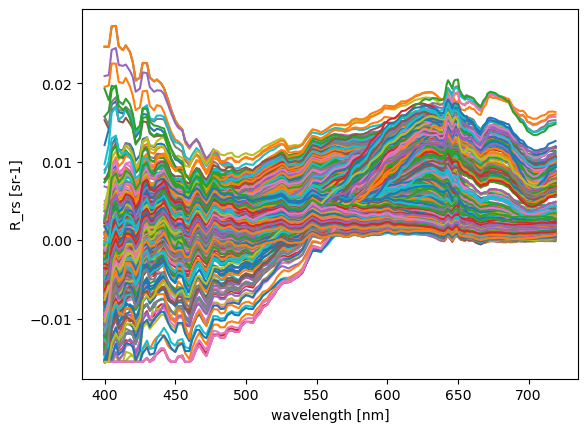

In [8]:
plt.plot(wavelengths, r_rs.T)
plt.xlabel('wavelength [nm]')
plt.ylabel('R_rs [sr-1]')
plt.show()

# QC

In [17]:
r_rs_min = r_rs.apply(np.min, axis=1)
print(len(r_rs_min), np.sum(r_rs_min<0))
ID = np.array(r_rs_min<0)
r_rs_= r_rs.copy()
r_rs_[ID,:] = r_rs[ID,:] - r_rs_min[ID]

1685 1638


InvalidIndexError: (array([False, False,  True, ...,  True,  True,  True]), slice(None, None, None))

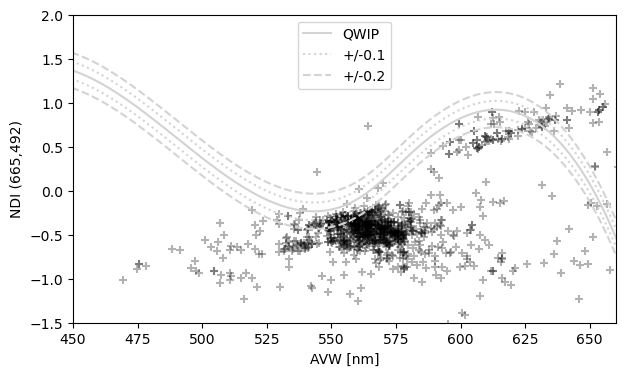

In [13]:


AVW = r_rs.apply(owt.avw, wavelengths=wavelengths, axis=1)
NDI = r_rs.apply(lambda x: indices.ndi(x.iloc[utils.find_closest(wavelengths, 665)[1]], x.iloc[utils.find_closest(wavelengths, 492)[1]]), axis=1)
colors = r_rs.apply(plotting.spectrum_to_hex, wavelengths=wavelengths, r=utils.find_closest(wavelengths, 610)[0], g=utils.find_closest(wavelengths, 550)[0], b=utils.find_closest(wavelengths, 480)[0], axis=1) 

qwip = np.array([owt.qwip(x) for x in AVW])
qwip_interp = UnivariateSpline(np.sort(AVW), qwip[np.argsort(AVW)])


xrange = np.arange(AVW.min()-np.abs(AVW.min()*0.01), AVW.max()+np.abs(AVW.min()*0.01), 1)

plt.figure(figsize=(7,4))
plt.scatter(AVW, NDI, c='k', marker='+', alpha=0.3)

plt.plot(xrange, qwip_interp(xrange), c="lightgrey", label="QWIP")
plt.plot(xrange, qwip_interp(xrange)+0.1,":", c="lightgrey", label="+/-0.1")
plt.plot(xrange, qwip_interp(xrange)-0.1,":", c="lightgrey")
plt.plot(xrange, qwip_interp(xrange)+0.2,"--", c="lightgrey", label="+/-0.2")
plt.plot(xrange, qwip_interp(xrange)-0.2,"--", c="lightgrey")

plt.legend()
plt.xlim(xrange.min(), xrange.max())
plt.xlim(450, 660)
plt.ylim(-1.5, 2)
plt.xlabel('AVW [nm]')
plt.ylabel('NDI (665,492)')

plt.show()

# Inversion

In [4]:
from bio_optics.water import fluorescence

# global inputs that don't change with fit params
a_md_spec_res = absorption.a_md_spec(wavelengths=wavelengths)
a_bd_spec_res = absorption.a_bd_spec(wavelengths=wavelengths)
a_w_res = resampling.resample_a_w(wavelengths=wavelengths)
a_i_spec_res = resampling.resample_a_i_spec_EnSAD(wavelengths=wavelengths)
b_bw_res = backscattering.b_bw(wavelengths=wavelengths, fresh=False)
b_i_spec_res = resampling.resample_b_i_spec_EnSAD(wavelengths=wavelengths)
da_W_div_dT_res = resampling.resample_da_W_div_dT(wavelengths=wavelengths)
h_C_res = fluorescence.h_C_double(wavelengths=wavelengths, W=0.75)
h_C_phycocyanin_res = fluorescence.h_C(wavelengths=wavelengths, fwhm=20, lambda_C=644)
h_C_phycoerythrin_res =fluorescence.h_C(wavelengths=wavelengths, fwhm=20, lambda_C=573)
omega_d_lambda_0_res = attenuation.omega_d_lambda_0()

E_0_res = resampling.resample_E_0(wavelengths=wavelengths)
a_oz_res = resampling.resample_a_oz(wavelengths=wavelengths)
a_ox_res = resampling.resample_a_ox(wavelengths=wavelengths)
a_wv_res = resampling.resample_a_wv(wavelengths=wavelengths)
n2_res = resampling.resample_n(wavelengths=wavelengths)

E_dd_res = downwelling_irradiance.E_dd(wavelengths=wavelengths)
E_dsa_res = downwelling_irradiance.E_dsa(wavelengths=wavelengths)
E_dsr_res = downwelling_irradiance.E_dsr(wavelengths=wavelengths)
E_d_res = E_dd_res + E_dsa_res + E_dsr_res

In [5]:
weights = np.ones(len(wavelengths))

In [6]:
@ray.remote
def invert_chunk(chunk,
                 params,
                 wavelengths,
                 weights,
                 a_md_spec_res,
                 a_bd_spec_res,
                 a_w_res,
                 a_i_spec_res,
                 b_bw_res, 
                 b_i_spec_res,
                 h_C_res,
                 h_C_phycocyanin_res,
                 h_C_phycoerythrin_res,
                 da_W_div_dT_res,
                 E_0_res,
                 a_oz_res,
                 a_ox_res,
                 a_wv_res,
                 E_dd_res,
                 E_dsa_res,
                 E_dsr_res,
                 E_d_res,
                 n2_res,
                 method="least_squares",
                 max_nfev=400):

    results = np.array([None] * chunk.shape[0])

    # make a copy of actual params object to enable in-parallel mutation
    chunk_params = params.copy()
    
    for i in np.arange(chunk.shape[0]):

        # chunk_params.add('theta_sun', value=np.radians(chunk[0,i,0]), vary=False)

        inv = hereon.invert(chunk_params, 
                            R_rs=chunk[i,:],
                            Ls_Ed = [],
                            wavelengths=wavelengths, 
                            weights=weights,
                            a_md_spec_res = a_md_spec_res,
                            a_bd_spec_res = a_bd_spec_res,
                            a_w_res = a_w_res,
                            a_i_spec_res = a_i_spec_res,
                            b_bw_res = b_bw_res, 
                            b_i_spec_res = b_i_spec_res,
                            h_C_res = h_C_res,
                            h_C_phycocyanin_res=h_C_phycocyanin_res,
                            h_C_phycoerythrin_res=h_C_phycoerythrin_res,
                            da_W_div_dT_res = da_W_div_dT_res,
                            E_0_res = E_0_res,
                            a_oz_res = a_oz_res,
                            a_ox_res = a_ox_res,
                            a_wv_res = a_wv_res,
                            E_dd_res = E_dd_res,
                            E_dsa_res = E_dsa_res,
                            E_dsr_res = E_dsr_res,
                            E_d_res = E_d_res,
                            n2_res = n2_res,
                            method=method,
                            max_nfev=max_nfev)
        results[i] = inv
        
    return results

In [7]:
params = lmfit.Parameters()
params.add('C_0', value=0, min=0, max=1000, vary=True) # brown
params.add('C_1', value=0, min=1e-6, max=1000, vary=True) # green
params.add('C_2', value=0, min=0, max=1000, vary=True) # cryptophyte
params.add('C_3', value=0, min=0, max=1000, vary=True) # cyano blue
params.add('C_4', value=0, min=0, max=1000, vary=True) # cyano red
params.add('C_5', value=0, min=0, max=1000, vary=True) # coccolithophores
params.add('C_6', value=0, min=0, max=1000, vary=True) # dinoflagellates
params.add('C_7', value=0, min=0, max=1, vary=True) # case-1
params.add('C_Y', value=0.1, min=0, max=30, vary=True) 
params.add('C_ism', value=1, min=0, max=1000, vary=True)
params.add('L_fl_lambda0', value=0, min=0, max=0.2, vary=True)
params.add('L_fl_phycocyanin', value=0, min=0, max=0.2, vary=False)
params.add('L_fl_phycoerythrin', value=0, min=0, max=0.2, vary=False)
params.add('b_ratio_C_0', value=0.002, vary=False) # brown
params.add('b_ratio_C_1', value=0.007, vary=False) # green
params.add('b_ratio_C_2', value=0.002, vary=False) # cryptophyte
params.add('b_ratio_C_3', value=0.001, vary=False) # cyano blue
params.add('b_ratio_C_4', value=0.001, vary=False) # cyano red
params.add('b_ratio_C_5', value=0.007, vary=False) # coccolithophores
params.add('b_ratio_C_6', value=0.007, vary=False) # dinoflagellates , chose 0.007 because of smaller cell size
params.add('b_ratio_C_7', value=0.007, vary=False) # case-1
params.add('b_ratio_md', value=0.0216, min=0.021, max=0.3756, vary=True) # max=0.0756
params.add('b_ratio_bd', value=0.0216, min=0.021, max=0.3756, vary=True) # max=0.0756
# params.add('b_ratio_d', value=0.0216, min=0.021, max=0.3756, vary=True)
params.add('A_md', value=13.4685e-3, vary=False)
params.add('A_bd', value=0.3893e-3, vary=False)
params.add('S_md', value=10.3845e-3, vary=False)
params.add('S_bd', value=15.7621e-3, vary=False)
params.add('S_cdom', value=0.0185, min=0.005, max=0.032, vary=True)
params.add('C_md', value=12.1700e-3, vary=False)
params.add('C_bd', value=0.9994e-3, vary=False)
params.add('K', value=0, min=0, vary=False)
params.add('lambda_0_cdom', value=440, vary=False)
params.add('lambda_0_md', value=550, vary=False)
params.add('lambda_0_bd', value=550, vary=False)
params.add('lambda_0_c_d', value=550, vary=False)
params.add('lambda_0_phy', value=676, vary=False)
params.add('gamma_d', value=0.3835, vary=False)
params.add('x0', value=1, vary=False)
params.add('x1', value=10, vary=False)
params.add('x2', value=-1.3390, min=-1.3390-0.0618, max=-1.3390+0.0618, vary=False)
params.add('A', value=0.0237, vary=False)
params.add('E0', value=1, vary=False)
params.add('E1', value=0.8987, vary=False)
params.add('W', value=0.75, vary=False) 
params.add('fwhm1', value=25, vary=False)
params.add('fwhm2', value=50, vary=False)
params.add('fwhm_phycocyanin', value=20, vary=False)
params.add('fwhm_phycoerythrin', value=20, vary=False)
params.add('lambda_C1', value=685, vary=False)
params.add('lambda_C2', value=730, vary=False)
params.add('lambda_C_phycocyanin', value=644, vary=False)
params.add('lambda_C_phycoerythrin', value=573, vary=False)
params.add('double', value=True, vary=False)
params.add('interpolate', value=True, vary=False)
params.add("Gw0", value=0.05881474, vary=False)
params.add("Gw1", value=0.05062697, vary=False)
params.add("Gp0", value=0.03997009, vary=False)
params.add("Gp1", value=0.1398902, vary=False)
params.add('error_method', value=0, vary=False)
params.add('theta_sun', value=np.radians(30), min=np.radians(0), max=np.radians(90), vary=False)
params.add('theta_view', value=np.radians(1e-10), min=np.radians(1e-10), max=np.radians(90), vary=False)
params.add('n1', value=1, vary=False)
params.add('n2', value=1.33, vary=False)
params.add('kappa_0', value=1.0546, vary=False)
params.add('fresh', value=False, vary=False)
params.add('T_W', value=25, min=0, max=40, vary=False)
params.add('T_W_0', value=20, vary=False)
params.add('P', value=1013.25, vary=False) 
params.add('AM', value=1, vary=False) 
params.add('RH', value=60, vary=False) 
params.add('H_oz', value=0.38, vary=False)
params.add('WV', value=2.5, vary=False) 
params.add('alpha', value=1.317, vary=False) 
params.add('beta', value=0.2606, vary=False) 
params.add('g_dd', value=0.02, min=-1, max=10, vary=True) 
params.add('g_dsr', value=1/np.pi, min=0, max=10, vary=True) 
params.add('g_dsa', value=1/np.pi, min=0, max=10, vary=True) 
params.add('d_r', value=0, min=0, max=0.1, vary=True) 
params.add('f_dd', value=1, vary=False) 
params.add('f_ds', value=1, vary=False) 
params.add('offset', value=0, min=-0.1, max=0.1, vary=False)
params.add('fit_surface', value=False, vary=False)

In [8]:
data = r_rs.values

num_chunks = 16  # Number of chunks to split the array into

chunk_size = r_rs.values.shape[0] // num_chunks  # Size of each chunk
chunks = [data[i:i+chunk_size,:] for i in range(0, data.shape[0], chunk_size)]  # Split the array into chunks

In [9]:
ray.shutdown()
import timeit
start = timeit.default_timer()

# Parallelize the processing of the chunks using ray
chunk_refs = [ray.put(chunk) for chunk in chunks]  # Put the chunks into the object store
result_refs = [invert_chunk.remote(chunk_ref,
                                   params=params,
                                   wavelengths=wavelengths,
                                   weights=weights,
                                   a_md_spec_res = a_md_spec_res,
                                   a_bd_spec_res = a_bd_spec_res,
                                   a_w_res = a_w_res,
                                   a_i_spec_res = a_i_spec_res,
                                   b_bw_res = b_bw_res, 
                                   b_i_spec_res = b_i_spec_res,
                                   h_C_res = h_C_res,
                                   h_C_phycocyanin_res = h_C_phycocyanin_res,
                                   h_C_phycoerythrin_res = h_C_phycoerythrin_res,
                                   da_W_div_dT_res = da_W_div_dT_res,
                                   E_0_res = E_0_res,
                                   a_oz_res = a_oz_res,
                                   a_ox_res = a_ox_res,
                                   a_wv_res = a_wv_res,
                                   E_dd_res = E_dd_res,
                                   E_dsa_res = E_dsa_res,
                                   E_dsr_res = E_dsr_res,
                                   E_d_res = E_d_res,
                                   n2_res = n2_res,
                                   method="least_squares", 
                                   max_nfev=1500) for chunk_ref in chunk_refs]  # Process the chunks in parallel

results = ray.get(result_refs) 

# Concatenate the results from the processed chunks
processed_data = np.concatenate(results)
    
stop = timeit.default_timer()
print('Time: ', stop - start)  

2024-04-10 16:05:08,087	INFO worker.py:1752 -- Started a local Ray instance.


Time:  422.93606839999995


In [10]:
results = processed_data

# QC

c:\users\dagmar\pycharmprojects\bio_optics\bio_optics\surface\surface.py:42: RuntimeWarning: invalid value encountered in add
  return (L_surf(L_s, rho_L) / E_d) + d_r


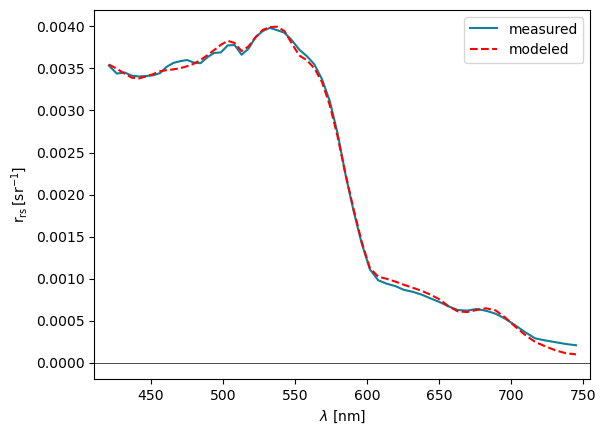

In [11]:
i = 500

R_rs_surf = model.forward_glint(wavelengths=wavelengths,
                                parameters=results[i].params,
                                E_d_res=E_d_res,
                                E_dd_res=E_dd_res,
                                E_dsa_res=E_dsa_res,
                                E_dsr_res=E_dsr_res,
                                n2_res=n2_res,
                                Ls_Ed=[])

plt.plot(wavelengths, r_rs.iloc[i], c='#0f7f9b', label="measured")
plt.plot(wavelengths, hereon.forward(parameters=results[i].params, 
                                     wavelengths=wavelengths, 
                                     a_md_spec_res = a_md_spec_res,
                                     a_bd_spec_res = a_bd_spec_res,
                                     a_w_res = a_w_res,
                                     a_i_spec_res = a_i_spec_res,
                                     b_bw_res = b_bw_res, 
                                     b_i_spec_res = b_i_spec_res,
                                     h_C_res=h_C_res,
                                     h_C_phycocyanin_res = h_C_phycocyanin_res,
                                     h_C_phycoerythrin_res = h_C_phycoerythrin_res,
                                     da_W_div_dT_res = da_W_div_dT_res,
                                     E_0_res = E_0_res,
                                     a_oz_res = a_oz_res,
                                     a_ox_res = a_ox_res,
                                     a_wv_res = a_wv_res,
                                     E_dd_res = E_dd_res,
                                     E_dsa_res = E_dsa_res,
                                     E_dsr_res = E_dsr_res,
                                     E_d_res = E_d_res,
                                     n2_res = n2_res,
                                     Ls_Ed=[]), '--', c='red', label='modeled')
if results[i].params['fit_surface'].value:
    plt.plot(wavelengths, R_rs_surf, c='skyblue', label="glint")
    plt.plot(wavelengths, r_rs.iloc[i] - R_rs_surf, c='darkblue', label="measured - glint")
plt.xlabel('$\lambda$ [nm]')
plt.ylabel('$\mathrm{r_{rs}} \/ [\mathrm{sr}^{-1}]$')
plt.hlines(0,300,1000, color='black', linewidth=0.5) #, linestyle='dotted')
plt.xlim(np.min(wavelengths)-10,np.max(wavelengths)+10)
# plt.ticklabel_format(style='scientific')
plt.legend()
plt.show()

# Simulated spectra

In [12]:
# Get glint
for i in np.arange(len(results)):
    if i == 0:
        R_rs_sim = hereon.forward(parameters=results[i].params, 
                                  wavelengths=wavelengths, 
                                  a_md_spec_res = a_md_spec_res,
                                  a_bd_spec_res = a_bd_spec_res,
                                  a_w_res = a_w_res,
                                  a_i_spec_res = a_i_spec_res,
                                  b_bw_res = b_bw_res, 
                                  b_i_spec_res = b_i_spec_res,
                                  h_C_res = h_C_res,
                                  h_C_phycocyanin_res = h_C_phycocyanin_res,
                                  h_C_phycoerythrin_res = h_C_phycoerythrin_res,
                                  da_W_div_dT_res = da_W_div_dT_res,
                                  E_0_res = E_0_res,
                                  a_oz_res = a_oz_res,
                                  a_ox_res = a_ox_res,
                                  a_wv_res = a_wv_res,
                                  E_dd_res = E_dd_res,
                                  E_dsa_res = E_dsa_res,
                                  E_dsr_res = E_dsr_res,
                                  E_d_res = E_d_res,
                                  n2_res = n2_res,
                                  Ls_Ed=[])
    else:
        R_rs_sim = np.vstack((R_rs_sim, hereon.forward(parameters=results[i].params, 
                                                       wavelengths=wavelengths, 
                                                       a_md_spec_res = a_md_spec_res,
                                                       a_bd_spec_res = a_bd_spec_res,
                                                       a_w_res = a_w_res,
                                                       a_i_spec_res = a_i_spec_res,
                                                       b_bw_res = b_bw_res, 
                                                       b_i_spec_res = b_i_spec_res,
                                                       h_C_res = h_C_res,
                                                       h_C_phycocyanin_res = h_C_phycocyanin_res,
                                                       h_C_phycoerythrin_res = h_C_phycoerythrin_res,
                                                       da_W_div_dT_res = da_W_div_dT_res,
                                                       E_0_res = E_0_res,
                                                       a_oz_res = a_oz_res,
                                                       a_ox_res = a_ox_res,
                                                       a_wv_res = a_wv_res,
                                                       E_dd_res = E_dd_res,
                                                       E_dsa_res = E_dsa_res,
                                                       E_dsr_res = E_dsr_res,
                                                       E_d_res = E_d_res,
                                                       n2_res = n2_res,
                                                       Ls_Ed=[])
                                        ))
        
R_rs_sim = pd.DataFrame(R_rs_sim, columns=wavelengths.astype(str))

In [13]:
# Write / Get params
for i in np.arange(len(results)):
    if i == 0:
        params = pd.DataFrame.from_dict(results[i].params.valuesdict().items()).set_index([0]).rename(columns={1: i}).T
    else:
        params = pd.concat([params, pd.DataFrame.from_dict(results[i].params.valuesdict().items()).set_index([0]).rename(columns={1: i}).T])

# params['GLORIA_ID'] = glomap.GLORIA_ID
params['GLORIA_ID'] = pin
params['C_phy'] = params[['C_0','C_1','C_2','C_3','C_4','C_5','C_6','C_7']].sum(axis=1)
outpath = r"E:\Documents\projects\EnsAD\inversion\HZG_HEREON_groups\results_MK\\"

params.to_csv(outpath + "inverted_IOP_bio_optics_HEREONfull_"+datasetName+"_V8AHall_bd_md_v2.txt", sep='\t', header=True, index=False)
R_rs_sim.to_csv(outpath + "inverted_Rrs_bio_optics_HEREONfull_"+datasetName+"_V8AHall_bd_md_v2.txt", sep='\t', header=True, index=False)

In [16]:
# # R_rs_sim['GLORIA_ID'] = df.GLORIA_ID
# R_rs_sim.to_csv(r'C:\Users\Marcel\OneDrive - Brockmann Consult GmbH\Desktop\EnsAD_DB_V0104_R_rs_sim.csv')

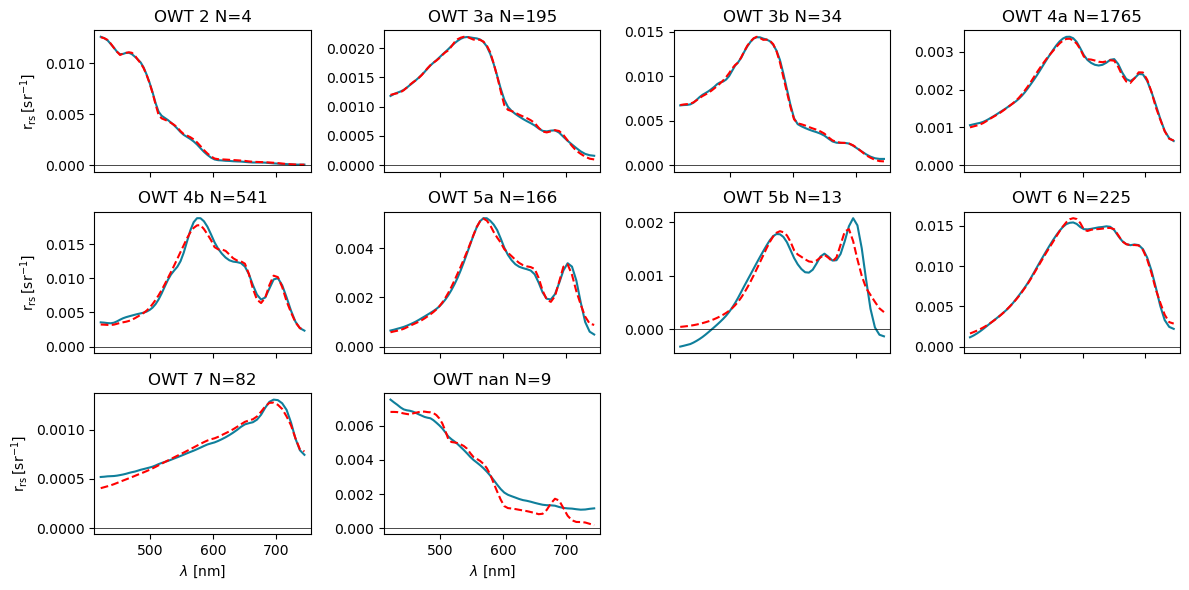

In [25]:
# Example spectrum per OWT
OWT = np.unique(owt_df['OWT'].values)
Nx = 4
Ny = 3
fig, ax = plt.subplots(nrows=Ny, ncols=Nx, figsize=(12,6), sharex=True)
ix, iy = (0,0)
for owt in OWT:
    ID = np.array(owt_df['OWT'].values == owt)
    ax[iy, ix].plot(wavelengths, r_rs.loc[ID,:].values[0,:], c='#0f7f9b', label="measured")
    ax[iy, ix].plot(wavelengths, R_rs_sim.loc[ID,:].values[0,:], '--', c='red', label='modeled')

    if iy == Ny-1:
        ax[iy, ix].set_xlabel('$\lambda$ [nm]')
    if ix==0:
        ax[iy, ix].set_ylabel('$\mathrm{r_{rs}} \/ [\mathrm{sr}^{-1}]$')
    ax[iy, ix].hlines(0,300,1000, color='black', linewidth=0.5) #, linestyle='dotted')
    ax[iy, ix].set_xlim(np.min(wavelengths)-10,np.max(wavelengths)+10)
    # plt.ticklabel_format(style='scientific')
    # ax[iy, ix].legend()
    ax[iy, ix].set_title('OWT '+ owt + " N="+ str(int(np.sum(ID))))
    ix +=1
    if ix==Nx:
        ix=0
        iy+=1

while iy <Ny:
    ax[iy, ix].axis('off')
    ix +=1
    if ix==Nx:
        ix=0
        iy+=1

fig.tight_layout()
plt.show()



c:\users\dagmar\pycharmprojects\bio_optics\bio_optics\helper\utils.py:166: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(np.sum((y_true - y_pred)**2)) / np.sum(y_true) * weights


ValueError: supplied range of [-2.1213661937668835, inf] is not finite

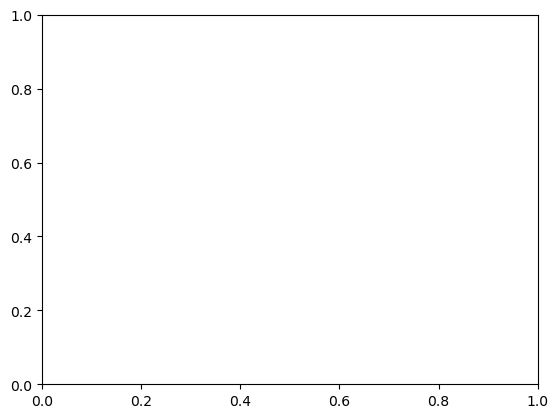

In [152]:
# Error, Residuals of spectral fit
rMAE = np.zeros(R_rs_sim.shape[0])
for i in range(len(rMAE)):
    rMAE[i] = np.mean(utils.compute_residual(r_rs.iloc[i].values, R_rs_sim.iloc[i,:].values, method=11))

plt.hist(np.log10(rMAE), 30, alpha=0.3)
ID = np.array(rMAE == np.max(rMAE))
print(np.arange(0, len(ID),1)[ID])

# Glint

In [90]:
# Get glint
for i in np.arange(len(results)):
    if i == 0:
        glint = model.forward_glint(wavelengths=wavelengths,
                                    parameters=results[i].params,
                                    E_d_res=E_d_res,
                                    E_dd_res=E_dd_res,
                                    E_dsa_res=E_dsa_res,
                                    E_dsr_res=E_dsr_res,
                                    n2_res=n2_res,
                                    Ls_Ed=[])
    else:
        glint = np.vstack((glint, model.forward_glint(wavelengths=wavelengths,
                                                      parameters=results[i].params,
                                                      E_d_res=E_d_res,
                                                      E_dd_res=E_dd_res,
                                                      E_dsa_res=E_dsa_res,
                                                      E_dsr_res=E_dsr_res,
                                                      n2_res=n2_res,
                                                      Ls_Ed=[])
                                  ))
        
glint = pd.DataFrame(glint, columns=wavelengths.astype(str))

In [15]:
glint

,418.2,423.9,429.3,434.5,439.6,444.5,449.4,454.2,458.9,463.6,...,660.0,666.4,672.9,679.5,686.1,692.8,699.6,706.4,713.3,720.3
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
974,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
975,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
976,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
# glint.to_csv(r'C:\Users\Marcel\OneDrive - Brockmann Consult GmbH\Cyanobloom\SpecBal_EnMAP_glint.txt')

In [91]:
# correct r_rs spectra for glint
R_rs = r_rs - glint

In [21]:
# R_rs.to_csv(r'C:\Users\Marcel\OneDrive - Brockmann Consult GmbH\Cyanobloom\SpecBal_EnMAP_R_rs.txt')

# Parameters

In [153]:
# Get params
for i in np.arange(len(results)):
    if i == 0:
        params = pd.DataFrame.from_dict(results[i].params.valuesdict().items()).set_index([0]).rename(columns={1: i}).T
    else:
        params = pd.concat([params, pd.DataFrame.from_dict(results[i].params.valuesdict().items()).set_index([0]).rename(columns={1: i}).T])

# params['GLORIA_ID'] = glomap.GLORIA_ID
params['C_phy'] = params[['C_0','C_1','C_2','C_3','C_4','C_5','C_6','C_7']].sum(axis=1)

In [23]:
# params.to_csv(r'C:\Users\Marcel\OneDrive - Brockmann Consult GmbH\Desktop\EnsAD_DB_V0104_fit_params.csv')

# Comparison

Text(0, 0.5, 'Cyano simulated')

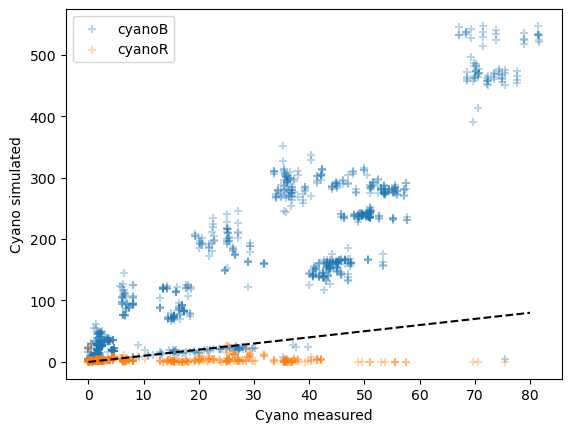

In [93]:
## Jorge: SpecBal
ID = np.array(params.C_3> 1E-2)
plt.scatter(df.Cyano[ID], params.C_3[ID], marker='+', alpha=0.3, label='cyanoB')
ID = np.array(params.C_4> 1E-2)
plt.scatter(df.Cyano[ID], params.C_4[ID], marker='+', alpha=0.3, label='cyanoR')
plt.plot((0, 80), (0,80), 'k--')
plt.legend()
plt.xlabel('Cyano measured')
plt.ylabel('Cyano simulated')

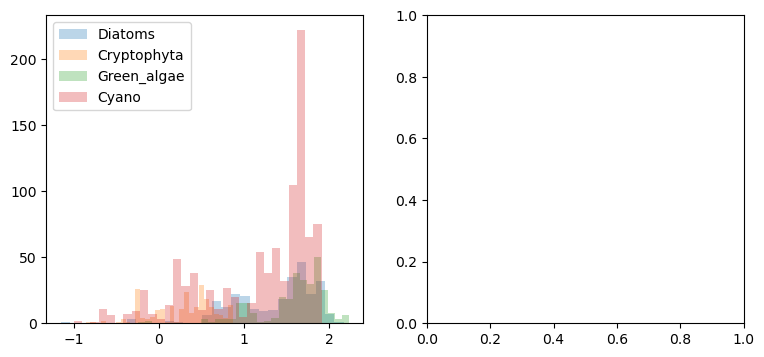

In [105]:
## Jorge: SpecBal
# print(df.columns.values)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9,4))
varList=['Diatoms', 'Cryptophyta',  'Green_algae', 'Cyano'] #'Chl_a', 'Planktothrix',
for v in varList:
    ID = np.array(df[v].values > 1E-2)
    ax[0].hist(np.log10(df[v].values[ID]), 30, alpha=0.3, label=v)
ax[0].legend()


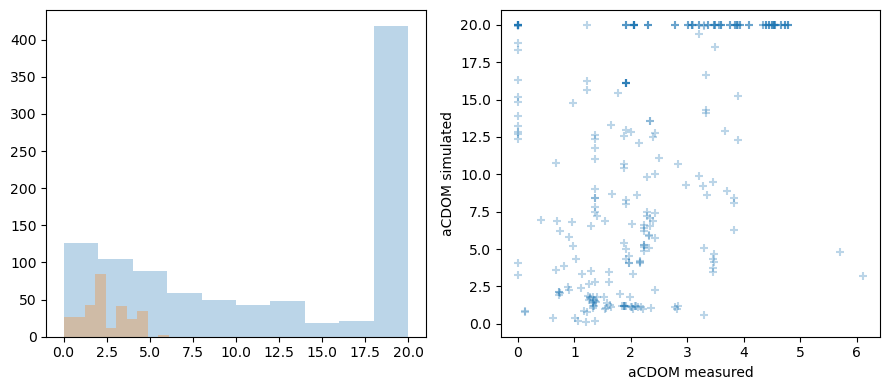

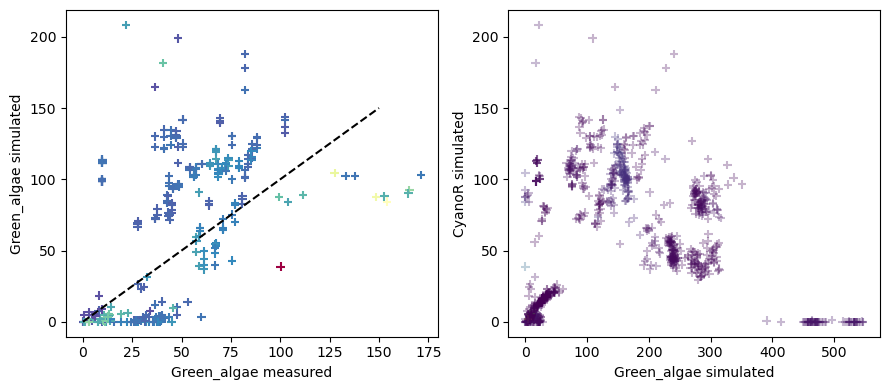

In [97]:
## Jorge: SpecBal
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9,4))
ax[0].hist(params.C_Y, alpha=0.3)
ax[0].hist(df.CDOM, alpha=0.3)
ax[1].scatter(df.CDOM, params.C_Y, marker='+', alpha=0.3)
ax[1].set_xlabel('aCDOM measured')
ax[1].set_ylabel('aCDOM simulated')
fig.tight_layout()



colorMap = plt.cm.get_cmap('Spectral_r')
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9,4))
# ax[0].scatter(df.Green_algae, params.C_1,  marker='+', c=params.C_3, cmap=colorMap)
ax[0].scatter(df.Green_algae, params.C_1,  marker='+', c=rMAE, cmap=colorMap)
ax[0].plot((0, 150), (0, 150.), 'k--')
ax[0].set_xlabel('Green_algae measured')
ax[0].set_ylabel('Green_algae simulated')
# ax[1].hist(df.Green_algae, alpha=0.3, label='insitu')
# ax[1].hist(params.C_1, alpha=0.3, label='simulated')
# ax[1].scatter( params.C_3, params.C_1, marker='+', c=params.C_Y, alpha=0.3)
ax[1].scatter( params.C_3, params.C_1, marker='+', c=rMAE, alpha=0.3)
ax[1].set_xlabel('Green_algae simulated')
ax[1].set_ylabel('CyanoR simulated')
# ax[1].legend()
fig.tight_layout()

L_fl_phycocyanin 729 979
L_fl_phycoerythrin 926 979
L_fl_lambda0 850 979


Text(0, 0.5, 'Fluorescence')

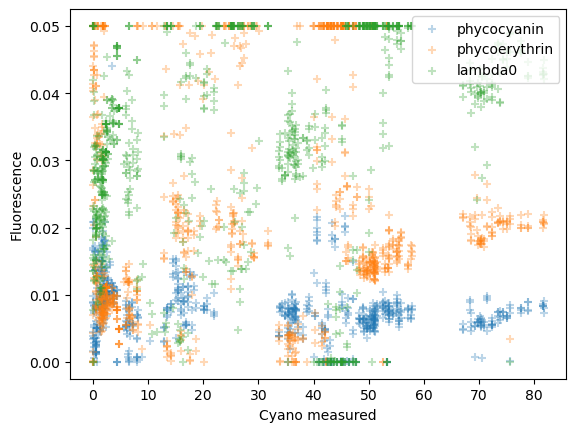

In [95]:
## Jorge: SpecBal
parList = ['L_fl_phycocyanin', 'L_fl_phycoerythrin', 'L_fl_lambda0']
for p in parList:
    ID = np.array(params[p] >1E-10)
    plt.scatter(df.Cyano.values[ID], params[p].values[ID], marker='+', alpha=0.3, label=p.split('_')[-1])
    print(p, np.sum(ID), len(ID))
# ID = np.array(params.L_fl_phycoerythrin >1E-10)
# plt.scatter(df.Cyano[ID], params.L_fl_phycoerythrin[ID], marker='+', alpha=0.3, label='phycoerythrin')
# ID = np.array(params.L_fl_lambda0 >1E-10)
# print(np.sum(ID), len(ID))
# plt.scatter(df.Cyano[ID], params.L_fl_lambda0[ID],  marker='+', alpha=0.3, label='chl')
plt.legend()
plt.xlabel('Cyano measured')
plt.ylabel('Fluorescence')

In [134]:
# GLOMAP / GLORIA
in_situ = pd.read_csv(r'Z:\projects\ongoing\EnsAD\workspace\data\insitu_GLORIA\GLORIA_meta_and_lab.csv', sep=',')
params['GLORIA_ID'] = pin
print(in_situ.columns.values)
print(params.columns.values)
comparison_df = pd.merge(in_situ, params, left_on='GLORIA_ID', right_on='GLORIA_ID')
print(comparison_df.shape)

['GLORIA_ID' 'Organization_ID' 'Dataset_ID' 'Sample_ID' 'LIMNADES_ID'
 'LIMNADES_UID' 'SeaBASS_ID' 'Data_collection_purpose'
 'Special_event_flag' 'Site_name' 'Country' 'Country_code' 'Latitude'
 'Longitude' 'Date_Time_UTC' 'Water_body_type' 'Water_type'
 'Elevation_asl' 'Wave_height' 'Wind_speed' 'Cloud_fraction' 'Depth'
 'Platform' 'Distance_from_platform' 'Platform_length' 'Platform_height'
 'Distance_to_shore' 'Landcover' 'Topography'
 'Distance_to_river_discharge' 'Optical_stability_of_water'
 'Rain_event_hour' 'Instrument_manufacturer' 'Instrument_model'
 'Last_calibration' 'Measurement_method' 'Lt_nadir' 'Lt_relative_azimuth'
 'Lsky_zenith' 'Lsky_relative_azimuth' 'Spectral_resolution'
 'Number_of_radiometers' 'Field_of_view_Lt_radiometer'
 'Field_of_view_Lu_radiometer' 'Skyglint_removal' 'Bias_removal_in_NIR'
 'Self_shading_correction' 'Viewing_angle_correction'
 'Additional_data_corrections' 'Availability_of_IOPs' 'Sample_depth'
 'Water_collection_equipment' 'Chl_method' 'Phae

In [136]:
outpath = r"E:\Documents\projects\EnsAD\inversion\HZG_HEREON_groups\results_MK\\"
comparison_df.to_csv(outpath + "inverted_IOP_bio_optics_HEREONfull_GLOMAP_V8AHall.txt", sep='\t', header=True, index=False)
R_rs_sim['GLORIA_ID'] = pin
R_rs_sim.to_csv(outpath + "inverted_Rrs_bio_optics_HEREONfull_GLOMAP_V8AHall.txt", sep='\t', header=True, index=False)

In [155]:
outpath = r"E:\Documents\projects\EnsAD\inversion\HZG_HEREON_groups\results_MK\\"
params.to_csv(outpath + "inverted_IOP_bio_optics_HEREONfull_EnMAPBalticSea_V8AHall.txt", sep='\t', header=True, index=False)
R_rs_sim.to_csv(outpath + "inverted_Rrs_bio_optics_HEREONfull_EnMAPBalticSea_V8AHall.txt", sep='\t', header=True, index=False)